In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist_data = input_data.read_data_sets('MNIST_data/')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def discriminator(images, reuse=False):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
    
        # First Convolutional and pool layers
        # This finds 32 different 5*5 features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1,1,1,1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # Second Convolutional layer
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1,1,1,1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

        # First Fully Connected layer
        d_w3 = tf.get_variable('d_w3', [7*7*64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7*7*64]) # Flatten
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Last Output layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        return tf.nn.sigmoid(d4), d4

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02)) # 3136 = 28*28*2*2
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)
    
    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])
    
    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1,2,2,1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])
    
    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimension of g4: batch_size * 28 * 28 * 1
    return g4

In [5]:
z_dimensions = 100 
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [6]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

In [7]:
tf.reset_default_graph()
batch_size = 50

# z_placeholder is for feeding input noise to the "generator"
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
# x_placeholder is for feeding input images to the "discriminator"
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name='x_placeholder')

# Gz holds the generated images
Gz = generator(z_placeholder, batch_size, z_dimensions)

# Dx will hold discriminator prediction probabilities
# for the real MNIST images
Dx_prob, Dx_logit = discriminator(x_placeholder)

# Dg will hold discriminator prediction probabilities for generated images
Dg_prob, Dg_logit = discriminator(Gz, reuse=True)

In [8]:
# Compare real images loss probabilities : 1 <-> Dx output
# tf.ones_like : Make same shape of 1 matrix
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx_logit, labels=tf.ones_like(Dx_logit)))

# Compare fake images loss probabilities : 0 <-> Dg outut
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg_logit, labels=tf.zeros_like(Dg_logit)))

d_loss = d_loss_fake + d_loss_real

# generator wants the discriminator to output a value close to 1 when it's given an image from the generator
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg_logit, labels=tf.ones_like(Dg_logit)))

In [9]:
tvars = tf.trainable_variables()
d_tvars = [var for var in tvars if 'd_' in var.name]
g_tvars = [var for var in tvars if 'g_' in var.name]

print(d_tvars)
print(g_tvars)

[<tf.Variable 'd_w1:0' shape=(5, 5, 1, 32) dtype=float32_ref>, <tf.Variable 'd_b1:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'd_w2:0' shape=(5, 5, 32, 64) dtype=float32_ref>, <tf.Variable 'd_b2:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'd_w3:0' shape=(3136, 1024) dtype=float32_ref>, <tf.Variable 'd_b3:0' shape=(1024,) dtype=float32_ref>, <tf.Variable 'd_w4:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'd_b4:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'g_w1:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'g_b1:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'g_w2:0' shape=(3, 3, 1, 50) dtype=float32_ref>, <tf.Variable 'g_b2:0' shape=(50,) dtype=float32_ref>, <tf.Variable 'g_w3:0' shape=(3, 3, 50, 25) dtype=float32_ref>, <tf.Variable 'g_b3:0' shape=(25,) dtype=float32_ref>, <tf.Variable 'g_w4:0' shape=(1, 1, 25, 1) dtype=float32_ref>, <tf.Variable 'g_b4:0' shape=(1,) dtype=float32_ref>]


In [10]:
d_trainer = tf.train.AdamOptimizer(0.0003).minimize(d_loss, var_list=d_tvars)
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_tvars)

In [11]:
tf.get_variable_scope().reuse_variables()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_Image', images_for_tensorboard, 5)
merged = tf.summary.merge_all()

logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '/'
writer = tf.summary.FileWriter(logdir, sess.graph)

INFO:tensorflow:Restoring parameters from pretrained-model/lossum_gan.ckpt-90000


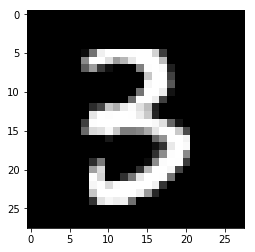

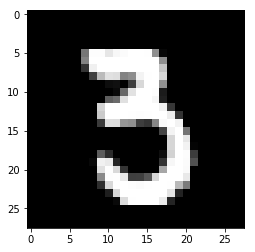

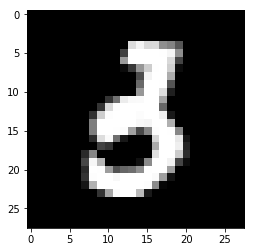

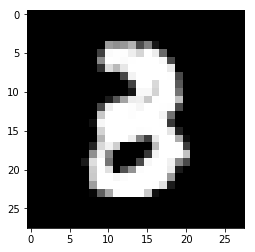

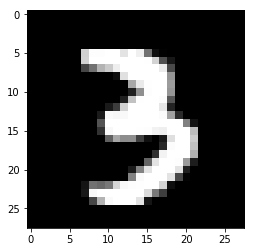

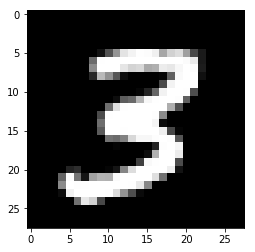

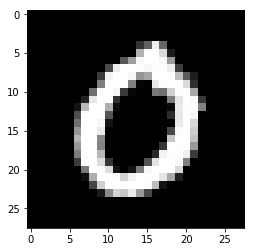

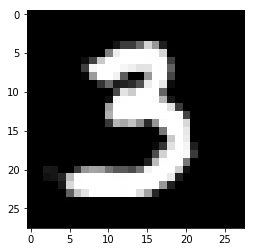

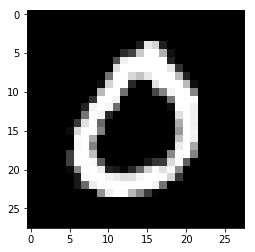

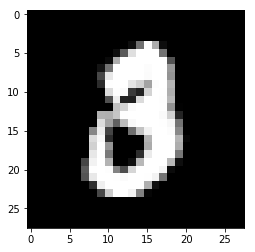

In [15]:
last_checkpoint_steps = 90000

saver = tf.train.Saver()
saver.restore(sess, 'pretrained-model/lossum_gan.ckpt-{}'.format(last_checkpoint_steps))

z_batch = np.random.normal(0, 1, [10, z_dimensions])
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder')
generated_images = generator(z_placeholder, 10, z_dimensions)
images = sess.run(generated_images, feed_dict={z_placeholder:z_batch})
for i in range(10):
    plt.imshow(images[i].reshape([28, 28]), cmap='gray')
    plt.show()